# Foreign Exchange Analysis Final Report

# Team 6
- Mahek Aggarwal
- John Gemmell
- Jacob Kulik
- David Pogrebitskiy


# Abstract:
This projects aims to examine, analyze, and explain seemingly random and unpredictable movements in foreign exchange rates, potentially informing future investment and asset allocation problems. We gathered years of daily exchange rates for numerous currencies and tried to find interesting relationships between them. By normalizing the exchange rates, we were able to put currencies side by side to find mutual changes that can later be generalized to provide useful and relevant information for prediction. By utilizing linear models and feature imporances, we found that aggregating multiple currencies and analyzing their behavior can help explain volatility in another currency. To more accurately test and integrate our findings, we suggest simulating investment actions like buying and selling based on movements that we've addressed in our linear models. Additionally, more advanced forcasting models should be used to see more robust results.

# Introduction:
The Foreign Exchange market is a global market for the trade of currencies. In free economies, the value of currencies are based off supply and demand. In some instances, countries peg their currency on another, meaning their currency moves in line with another. The fluctuation of currencies can also give economic indicators,
such as which economies move in line with one another and the effect of current events. Further, there are many factors that affect currency value, such as trade investment, tourism, and geopolitics. Inflation is a very influential economic phenomenon, and on top of influencing unemployment, it can have an effect on foreign exchange rates.

We are analyzing how the fluctuation of one currency can predict the fluctuation of another.

<img src="https://cdn.corporatefinanceinstitute.com/assets/foreign-exchange.jpeg" width=400px>

# Data Description:
To wrangle foreign exchange rates, request calls were made to [ExchangeRate API](https://exchangerate.host/#/#docs). These calls provided time-series data for each of the specified currencies. Because of the flexibility of the API, there were several customizable parameters to fine-tune the API request (date range, source, amount, base, etc). The API was limiting each request to 2 years of daily data, so we made functions to make multiple requests between our start and end dates and concatenating them together. The final result was about 13 years of daily exchange rates for multiple currencies (~4,700 rows).

# Pipeline Overview:
We accomplished this task with the following functions:
## API and Formating Functions:
- `api_req()`
    - Makes an initial request to the API that includes time-series data of all of our
    desired parameters using Python's kwargs feature.

- `merge_df_by_year()`
    - Merge multiple years worth of data into one dataframe because the API limits us
    to 2 years of data per request.

## Analysis and Visualizations:
- `scale_cur()`
    - Scales the currencies to be between 0 and 1 using MinMaxScaler, helping with plotting and analyzing.
- `moving_avg()`
    - Calculates a moving average of every currency of the dataframe using a specified window.
- `calc_pct_change()`
    - Calculates the percentage change between all values, helping to normalize and analyze.

## Machine Learning
- `r2_scoring()`
    - Calculates R2 of cross-validated simple linear regression model.
- `randomness_test()`
    - Checks variable independence, constant variance, and normality assumptions for linear regression.
- `get_mse()`
    - Calculate the Mean Squared Error between true and predicted values.
- `show_fit()`
    - Plot the fit of the linear regression with associated metrics.
- `disp_regress()`
    - Runs a multiple regression model and calculates the r2 of the model.
- `plot_feat_import()`
    - Plot importance of features in a multiple regression model.
- `disp_rfr_regress()`
    - Runs a random forest regression model and calculates the r2 of the model.


In [174]:
import requests
from pprint import pprint
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as py
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [175]:
def api_req(**kwargs):
    '''
    This function calls an exchange rate api and builds a df with the data
    A list of strings (currencies) is a parameter
    returns a transpose dataframe where the dates are the indices

    Params for API call kwargs:
        start_date [required] String format (YYYY-MM-DD)
        end_date [required] String format (YYYY-MM-DD)
        base. example:base=USD
        symbols	[optional] Enter a list of comma-separated currency codes to limit output
            currencies. example:symbols=USD,EUR,CZK
        amount	[optional] The amount to be converted. example:amount=1200
        places	[optional] Round numbers to decimal place. example:places=2
        source	[optional] You can switch source data between (default) forex, bank view or crypto currencies. (ecb, crypto)
    '''

    params = kwargs
    url = 'https://api.exchangerate.host/timeseries?'
    
    # Query the API call
    response = requests.get(url, params=params)
    data = response.json()

    return pd.DataFrame(data['rates']).T

api_req(start_date='2021-01-01', end_date='2022-01-01', base='USD', symbols='GBP,RUB,EUR,DKK')

,DKK,EUR,GBP,RUB
2021-01-01,6.092900,0.821300,0.731368,73.944993
2021-01-02,6.092899,0.824063,0.731368,73.944989
2021-01-03,6.082472,0.817388,0.731935,74.108816
2021-01-04,6.073148,0.816286,0.736620,73.532982
2021-01-05,6.049919,0.813219,0.734071,74.170118
...,...,...,...,...
2021-12-28,6.571598,0.884210,0.744312,73.642400
2021-12-29,6.548574,0.880921,0.741268,73.951951
2021-12-30,6.560552,0.882704,0.740360,74.703970
2021-12-31,6.538054,0.879286,0.739386,74.767039


In [176]:
def merge_df_by_years(start_year, end_year, **kwargs):
    '''
    Creates a dataframe containing the exchange rates from the start year to the end year.
    Merge multiple years worth of data into one dataframe from the API call because it limits
    the amount of row in a request.
    :param start_year (int):
    :param end_year (int):
    
    :return: DataFrame
    '''

    df_output = pd.DataFrame()
    
    # Iterate through the the desired years
    for year in range(start_year, end_year + 1):
        params = {
            'start_date': f'{year}-01-01',
            'end_date': f'{year}-12-31',
        }
        # Update the params with the other input params
        kwargs.update(params)
        df_year = api_req(**kwargs)
        
        # Stack all the dataframes because of the API limitting
        df_output = pd.concat([df_output, df_year])
    df_output.dropna(inplace=True, axis=0)
    return df_output

df = merge_df_by_years(2010, 2022, symbols='GBP,EUR,RUB,JPY,AUD,DKK', base='USD') 
df

,JPY,DKK,GBP,RUB,AUD,EUR
2010-01-01,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-02,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-03,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-04,92.477815,5.158902,0.620632,30.297421,1.095743,0.693289
2010-01-05,91.556453,5.179730,0.625226,29.990185,1.096478,0.696088
...,...,...,...,...,...,...
2022-11-26,139.066126,7.150801,0.826859,60.724338,1.481637,0.960409
2022-11-27,139.195055,7.163304,0.828812,60.465997,1.487295,0.963244
2022-11-28,138.842107,7.186891,0.836411,61.497540,1.503762,0.966926
2022-11-29,138.563847,7.194675,0.836730,60.794571,1.495866,0.968067


In [177]:
def scale_cur(df):
    '''
    Scales the exchange rates for a dataframe of currencies
    df- dataframe
    returns a scaled dataframe
    '''

    cols = df.columns
    # fitting a scaler to make the data comparable visually
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=cols)

    # updating indexes to be dates
    df_scaled.index = df.index
    return df_scaled

df_scaled = scale_cur(df)
df_scaled

,JPY,DKK,GBP,RUB,AUD,EUR
2010-01-01,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-02,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-03,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-04,0.225159,0.049412,0.107887,0.030892,0.227344,0.053085
2010-01-05,0.212761,0.057041,0.120938,0.028243,0.228224,0.060660
...,...,...,...,...,...,...
2022-11-26,0.852072,0.778922,0.693760,0.293287,0.689552,0.775967
2022-11-27,0.853807,0.783501,0.699309,0.291059,0.696329,0.783639
2022-11-28,0.849058,0.792140,0.720897,0.299955,0.716052,0.793603
2022-11-29,0.845314,0.794990,0.721803,0.293892,0.706595,0.796691


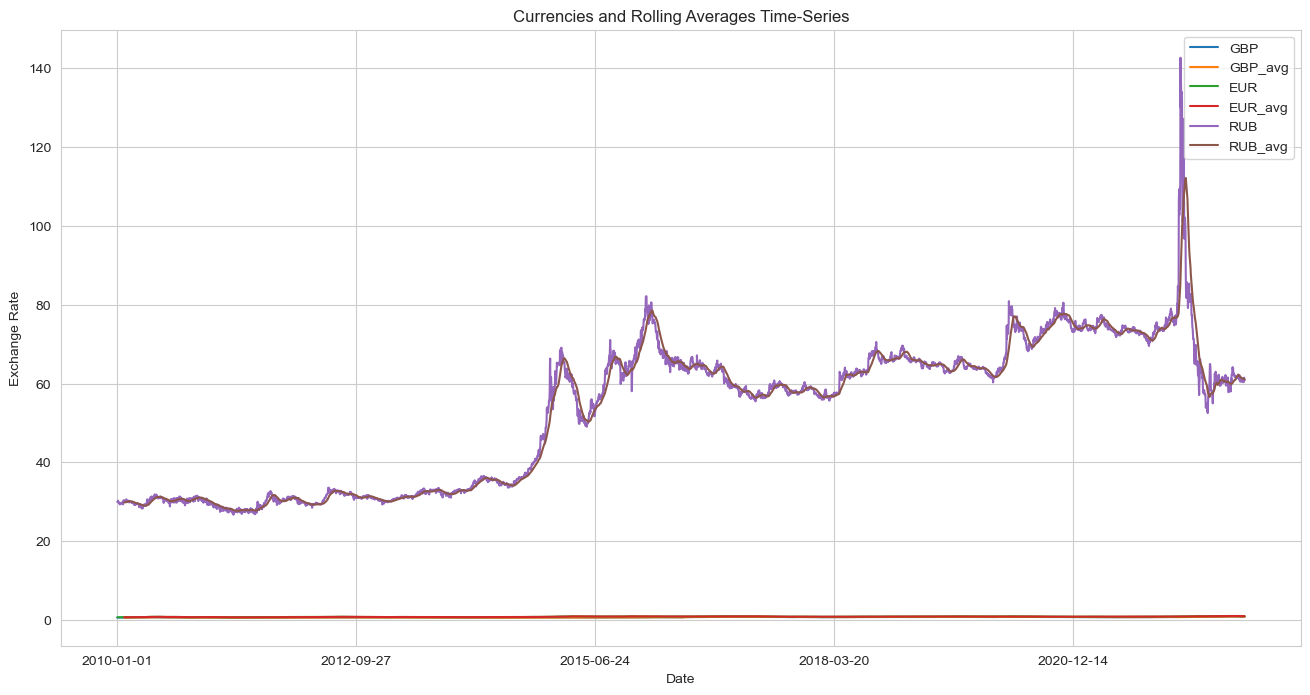

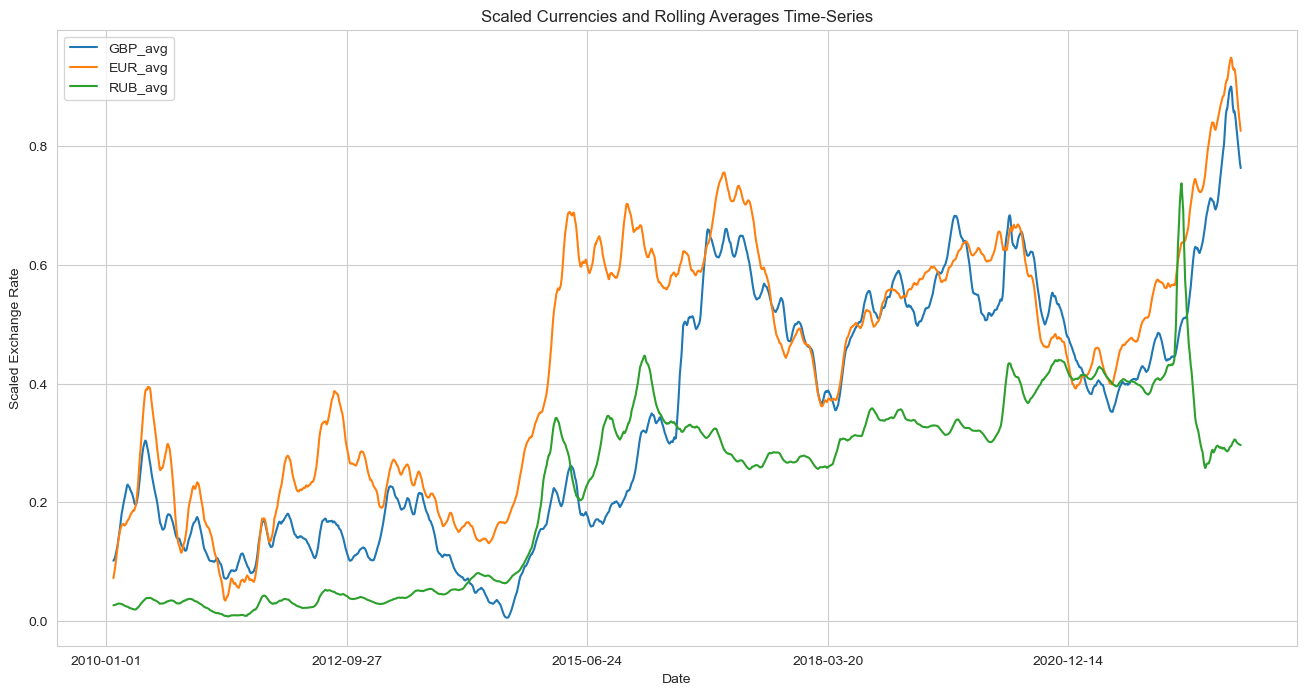

In [178]:
def moving_avg(df, roll, *curs, scale=True):
    '''
    Creates a moving average plot for a given number of currencies and their moving averages
    df - dataframe, roll - int and number of days to be smoothed, *curs - list of currencies
    returns an updated df and a plot
    '''
    fig, ax = plt.subplots()

    # Creating label based off graph type
    plt.xlabel('Date')
    if scale:
        plt.ylabel('Scaled Exchange Rate')
        plt.title('Scaled Currencies and Rolling Averages Time-Series')
    else:
        plt.ylabel('Exchange Rate')
        plt.title('Currencies and Rolling Averages Time-Series')

    # iterating across currencies
    for cur in curs:
        cur_idx = cur + '_avg'
        # creating a rolling mean column and plotting both
        df[cur_idx] = df[cur].rolling(roll).mean()
        if scale:
            df[[cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
        else:
            df[[cur, cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
    return df

df_usd = moving_avg(df, 30,'GBP','EUR','RUB', scale=False)
df_usd_scaled = moving_avg(df_scaled, 30, 'GBP', 'EUR', 'RUB', scale=True)
plt.show()

## Important Note:
Although scaled, the y-axis still represents the exchange rate in relation to the US Dollar. In other words, when a currencie's exchange rate is incresasing on the chart, it's value lessens because it takes more of that currency to trade for $1. Because of this, movements are interpreted opposite to your intution. Decrease is good and increase is bad.


## Interpretation:
By exploring the above graph, we can see a few key takeaways. First, we can see very clearly that global events and/or crises can be seen reflected on a countries exchange rate plot. Namely, we can see the European Debt Crisis in 2015, Brexit at the end of 2020, and Russia's economic downfall after their invasion of Ukraine. Additionally, by looking at these exchange rates on top of each other, we can begin to see the relationships between currencies. Specificically, we can see that the overall, long-term trend of each currency decreases in value. Looking closely, we can see that GBP tends to follow EUR but not immediately. In other words, GBP appears to have a delayed response to changes in the EUR.

In [179]:
def calc_pct_change(df):
    """
    Calculates the pct change between each observation in the dataframe
    Params:
        df(DataFrame): a dataframe of time-series exchange rates
    """
    pct_df = df.pct_change()
    
    # Rename each of the columns for the pct change
    for col in pct_df.columns:
        pct_df.rename(columns={col: col+"_pct_change"}, inplace=True)
    
    # Concat the original with pct change df
    return pct_df, pd.concat([df, pct_df], axis=1)



In [180]:
df = merge_df_by_years(2010, 2022, symbols='GBP,EUR,RUB,JPY,AUD,DKK', base='USD')
pct_df, pct_concated = calc_pct_change(df)

# Analysis:

* We will analyze our time-series data of the currencies using different linear models such as basic linear regression and multiple linear regression and comparing these models to determine which one yields the best results.

* We can incorporate our scaled exchange rate info and percent changes to make more sense of currency pegs and the fluctuation of excgange rates.

* Additionally, regression of various currencies can be calculated and analyzed to determine which currencies track with one another.

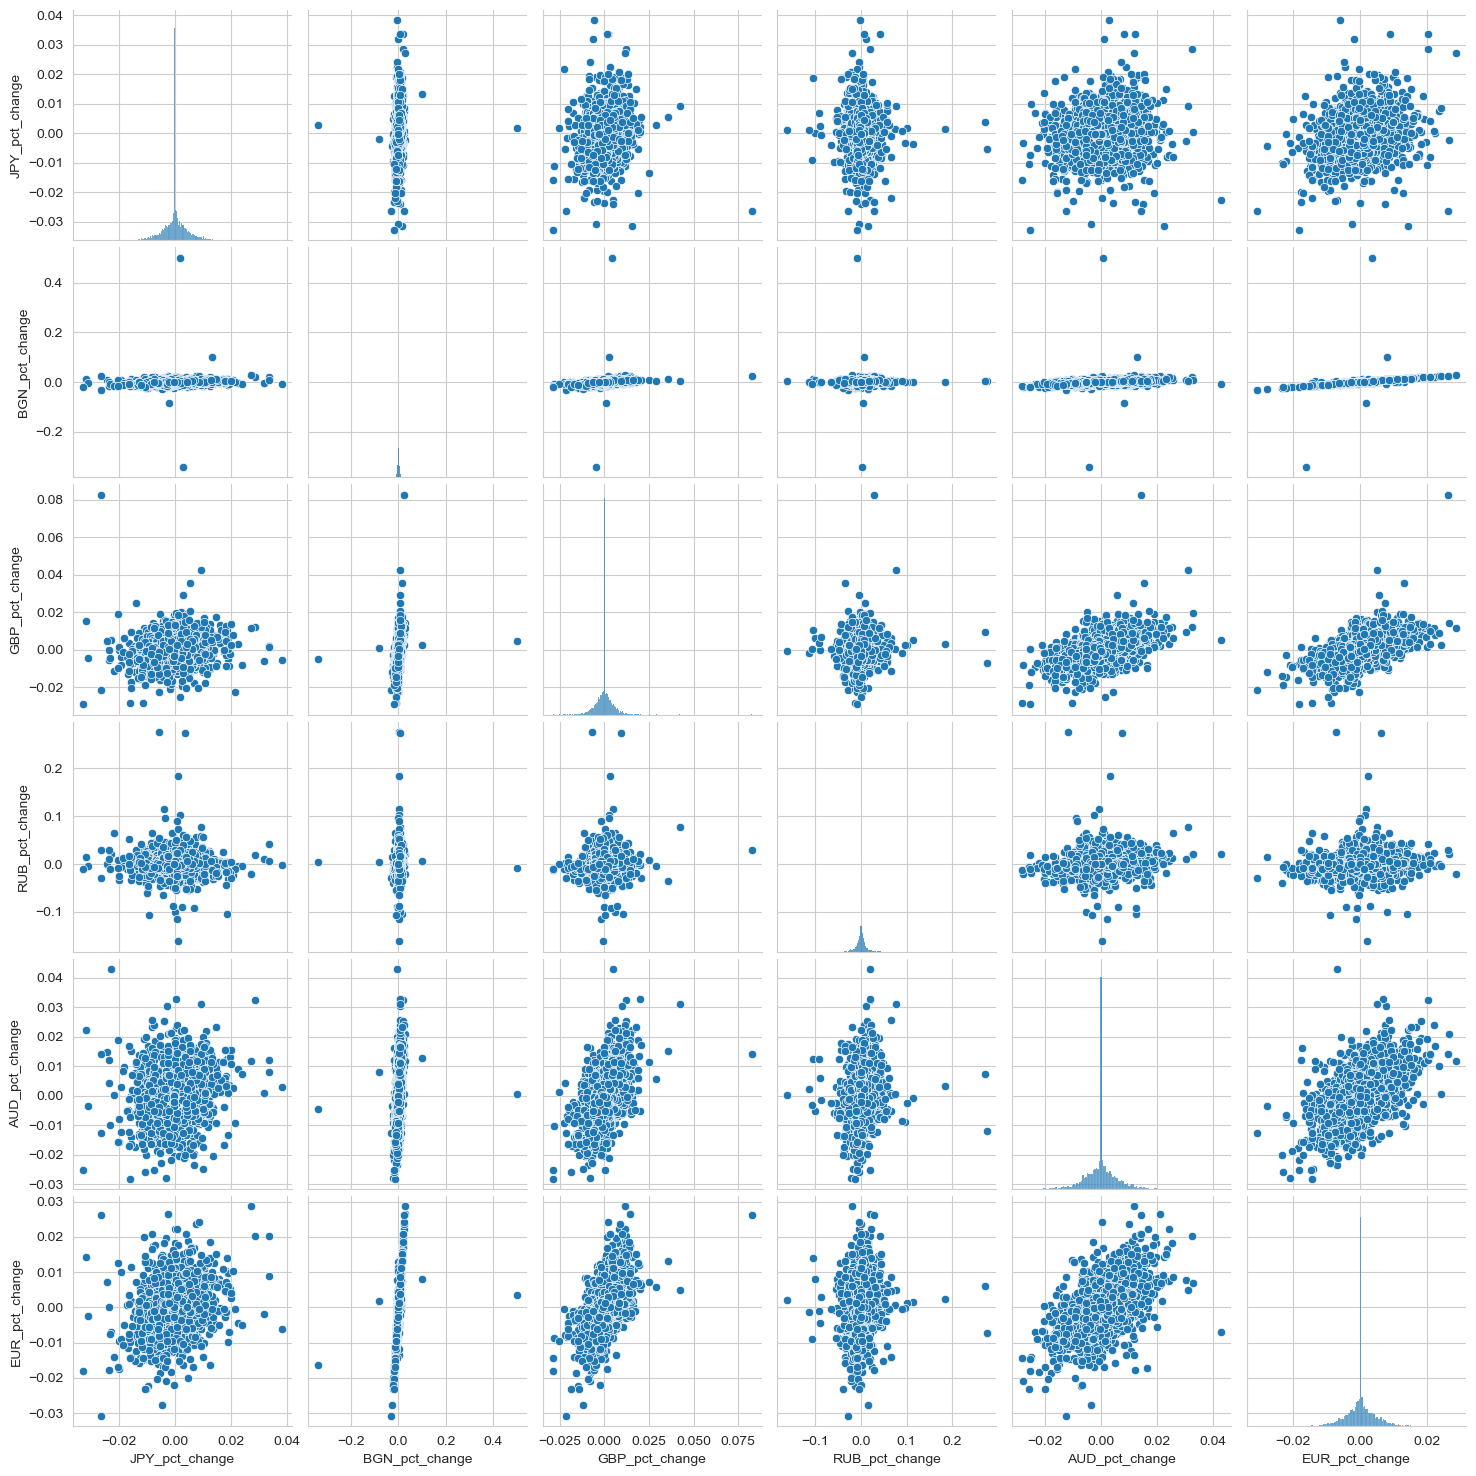

In [181]:
sns.pairplot(pct_df.dropna(axis=0))
plt.show()

## Interpretation:
The above pairplot allows us to easily inspect each pairwise relationship. Instead of looking at raw exchange rates, we are now looking at percent change which normalizes the scales and removes the time variable in a way. We can see that, for the most part, there isn't an immediate relationship between currencies, apart for DKK and EUR. This can actually be explained by the fact that DKK has a fixed exchange rate policy with EUR, meaning they should have identical movements. We will move into more advanced techniques to better characterize the movement in a currency.


### Machine Learning

Our chosen machine learning tools were Linear Regression and Multiple Regression.

### Regression for percent change analysis

Regression was chosen as we wanted to see if there was a linear relationship between the percentage change of the Euro and the Pound. We chose these currencies as they are extremely popular and both used in Europe, and even with the British exit from the European Union, it is useful to see the data up until and after this exit.

In [182]:
def r2_scoring(df, col1, col2, n_splits):
    """
    This runction calculates the R2 Score of a simple linear regression
    
    Params:
        df (DataFrame): The dataframe containing all the data
        col1 (String): the name of x axis feature
        col2 (String): the name of the y axis feature
        n_splits(int): Number of folds for kfold cross validation
    """
    # Seperate features and targets
    x = np.array(df[col1])[1:].reshape(-1, 1)
    y = np.array(df[col2])[1:]
    
    # Create KFold object
    kfold = KFold(n_splits=n_splits)

    # Create Regression object
    reg = LinearRegression()

    # Empty array to fill in with predictions
    y_pred = np.empty_like(y)

    for train_idx, test_idx in kfold.split(x, y):
        # get training data
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        
        # get test data    
        x_test = x[test_idx, :]

        # fit data
        reg = reg.fit(x_train, y_train)

        # estimate on test data
        y_pred[test_idx] = reg.predict(x_test)
    
    return r2_score(y_true=y, y_pred=y_pred)

In [183]:
r2_scoring(pct_df, 'GBP_pct_change', 'EUR_pct_change', 10)

0.3326983827591897

In [184]:
def randomness_test(df, col1, col2):
    '''
    This function checks the independence of 2 columns of the percent change df
    Parameters: df - dataframe, col1 and col2 - strings with col names
    Returns x and y lists, slope and intercept floats, and makes plots
    '''
    #Checking Independence
    # getting rid of na vals and reshaping
    x_na = np.array(df[col1])
    x = x_na[np.logical_not(np.isnan(x_na))].reshape((-1, 1))
    
    # getting rid of na vals
    y_na = np.array(df[col2])
    y = y_na[np.logical_not(np.isnan(y_na))]
    
    reg = LinearRegression()
    reg.fit(x, y)

    # same as b_1
    slope = reg.coef_[0]

    # same as b_0
    intercept = reg.intercept_
    
    y_pred_bmg = slope * x + intercept
    
    # plotting using index and error vals
    errors = y.reshape((-1,1)) - y_pred_bmg
    plt.scatter(x = range(len(y)), y = errors)
    plt.xlabel('index')
    plt.ylabel('errors')
    plt.show()
    
    # Checking Constant Variance
    plt.scatter(x = x, y = errors)
    plt.xlabel(col1)
    plt.ylabel('errors')
    plt.show()
    
    # Checking Normality
    stats.probplot(errors.reshape((-1,)), dist="norm", plot=py)
    py.show()
    
    return x, y, slope, intercept

In [185]:
def get_mse(y_true, y_pred):
    '''
    Calculates the mean squared distance between the predicted and actual y
    Takes 2 lists, y_true and y_pred
    Returns a mean squared error value
    '''
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)


def show_fit(x, y, slope, intercept):
    '''
    This function creates a linear regression
    Parameters - x and y are lists, slope and intercept are floats
    Returns nothing, creates a linear regression plot
    '''
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    plt.legend()
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    R2_easy = r2_score(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.5f}, RMSE = {mse**0.5:.3f}, R^2 = {R2_easy:.3f}')
    plt.show()

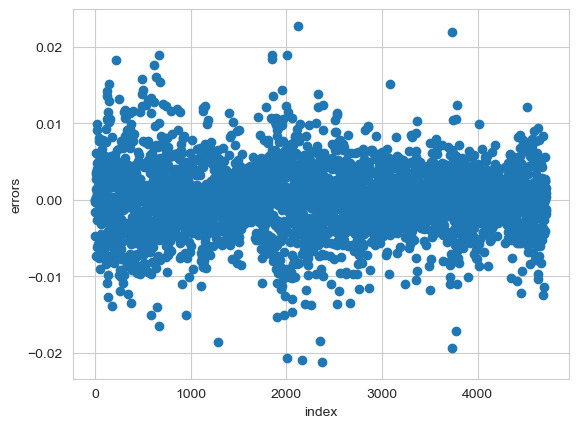

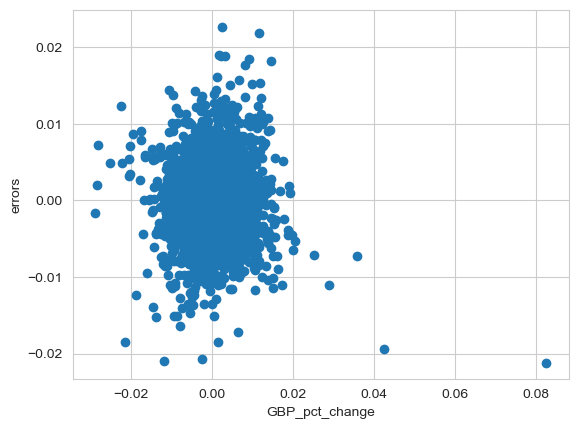

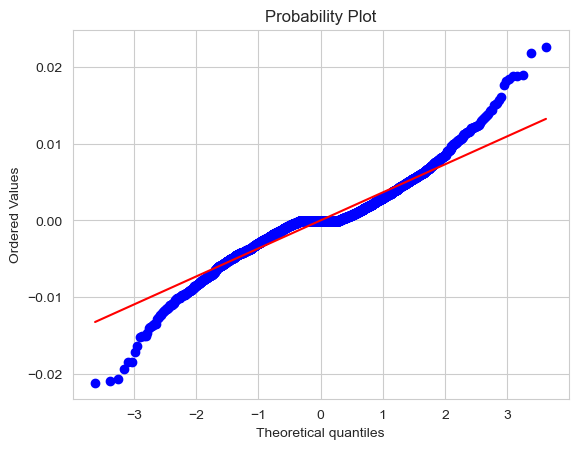

In [186]:
# Testing the data on 3 tests to see if it is random and possible to use a regression on
x, y, slope, intercept = randomness_test(pct_df, 'GBP_pct_change', 'EUR_pct_change')

The first plot shows that there is no relationship between index and error, meaning the values are random. The second plot shows that there is no relationship between healing done and error, meaning different pound percent change values have random error values. Finally, the probability plot further conveys that the data is random and worth using as the quantile points match a 45 degree line with ordered values. In conclusion, because we are meeting these random assumptions, the model is useful and should be used.

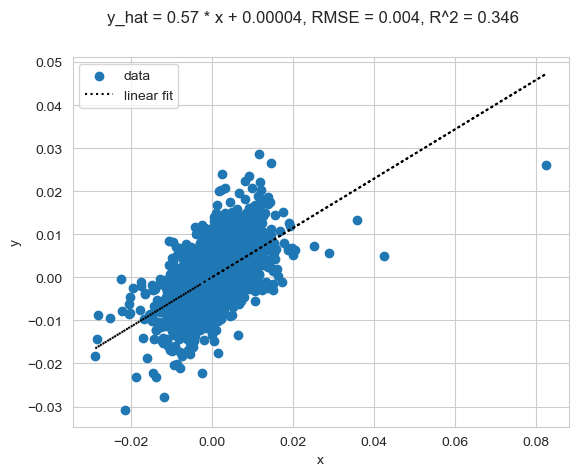

In [187]:
show_fit(x, y, slope, intercept)

In [188]:
# Now looking at the DKK and the EUR
r2_scoring(pct_df, 'DKK_pct_change', 'EUR_pct_change', 10)

-2.929320752577956

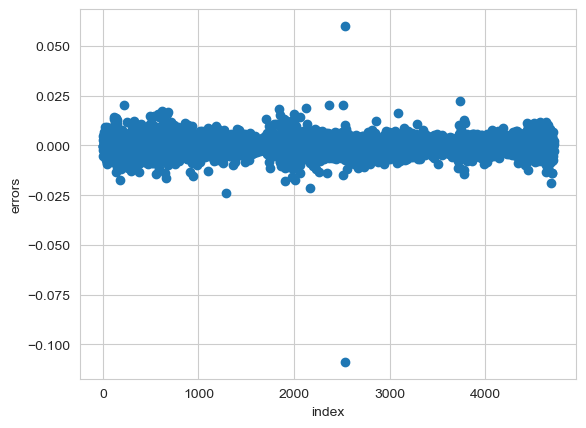

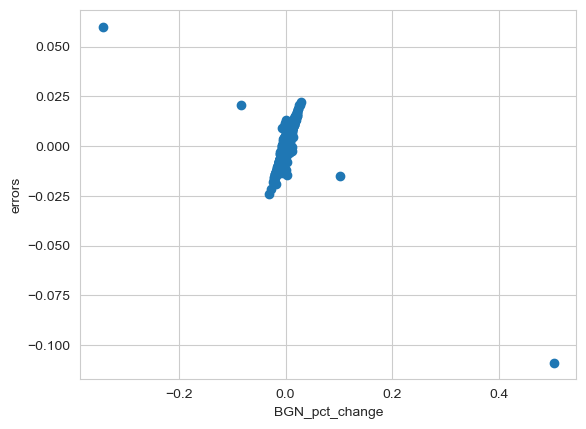

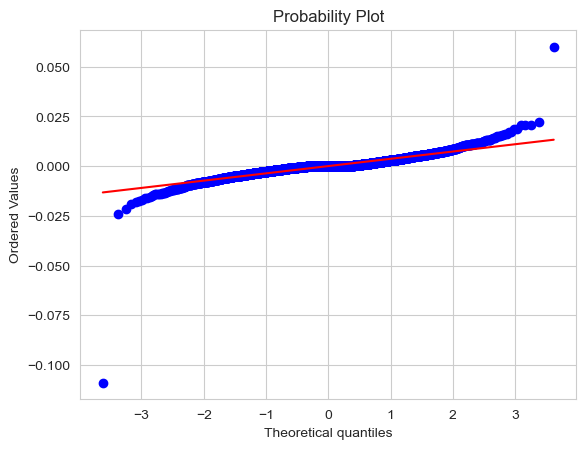

In [189]:
# Now testing DKK and EUR data on 3 tests to see if it is random and possible to use a regression on
x, y, slope, intercept = randomness_test(pct_df, 'DKK_pct_change', 'EUR_pct_change')

The first plot shows that there is a relationship between index and error, as all indices have similar errors, meaning the values are not random. The second plot shows that there is a relationship between DKK percent changes and error, meaning different pound percent change values have virtually the same error values (close to 0). Finally, the probability plot further conveys that the data is not random and not worth using as the quantile points do not match a 45 degree line with ordered values. In conclusion, the model is not random and therefore not useful, however it would be interesting to visualize and see why.

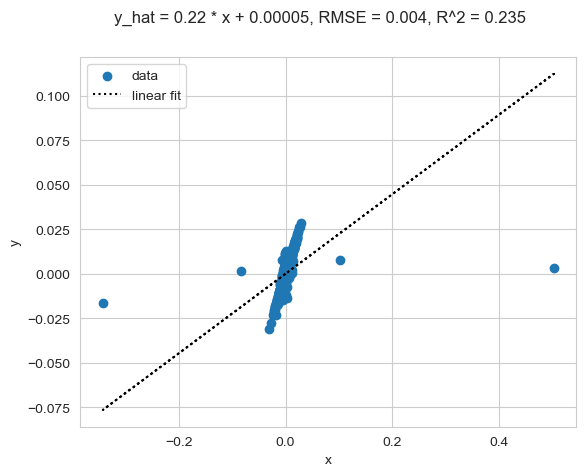

In [190]:
show_fit(x, y, slope, intercept)

### Results

As seen above, we created Linear regression plots and calculated R2 scores for the percentage changes between the Pound the Euro, and then the Krone and the Euro. It is interesting to note that the plots for the GBP vs. EUR pass the randomness test, however they produce a R2 value of only 0.34. With 10 KFolds, this R2 score slightly decreases to 0.33. Although there is a positive relationship between the change in the Pound and a change in the Euro, only around 34% of the variability in 	$\Delta$EUR can be explained by $\Delta$GBP.

To put this into perspective, we conducted the same tests on the Danish Krone and the Euro. Denmark is country that is part of the European Union yet chooses to use their own currency, so this is perfect for comparison against the Pound. $\Delta$DKK against $\Delta$EUR shows an R2 value of 0.99, meaning 99% of the variability in 	$\Delta$EUR can be explained by $\Delta$GBP. This is fantastic, except after a further look at the data through 3 randomness tests, we see that this is because the Krone and the Pound are not random. In fact, with further research, our results prove the fact that the Krone is pegged to the Euro. According to the Danish National Bank, "...the value of the Danish krone is to be kept stable against the euro", due to their monetary policy.

Source: https://www.nationalbanken.dk/en/about_danmarks_nationalbank/frequently_asked_questions/Pages/Denmarks-fixed-exchange-rate-policy.aspx#:~:text=Denmark%20conducts%20a%20fixed%20exchange%20rate%20policy%20against%20the%20euro,by%20way%20of%20monetary%20policy.

### Multiple regression for percent change analysis

Multiple regression was chosen as we wanted to see if there was a relationship between the percentage changes of the EU non-Euro countries and the Euro. We chose these currencies as it is rare for EU countries to use their own, and we wanted to see if any relationships existed. With these multiple features, we were hoping to be able to predict the movement in the Euro.

In [191]:
def disp_regress(df, x_feat_list, y_feat, verbose=True):
    """ linear regression, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        reg (LinearRegression): model fit to data
    """
    # initialize regression object
    reg = LinearRegression()

    # get target variable
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    if verbose:
        # print model  
        model_str = y_feat + f' = {reg.intercept_:.2f}'
        for feat, coef in zip(x_feat_list, reg.coef_):
            model_str += f' + {coef:.2f} {feat}'
        print(model_str)

        # compute / print r2
        r2 = r2_score(y_true=y, y_pred=y_pred)
        print(f'r2 = {r2:.3}')
    
    return reg

In [192]:
eu_df = merge_df_by_years(2010, 2022, symbols='EUR,BGN,HRK,CZK,HUF,PLN,RON,SEK', base='USD')
eu_pct_df, pct_concated = calc_pct_change(eu_df)

#calculating the r2 score of our model on our list of percent change x values
currencies = [x+'_pct_change' for x in ['BGN','CZK','HRK','HUF','PLN','RON','SEK']]
eu_r2 = disp_regress(eu_pct_df[1:], x_feat_list = currencies, y_feat = 'EUR_pct_change')

EUR_pct_change = 0.00 + 0.04 BGN_pct_change + 0.33 CZK_pct_change + 0.10 HRK_pct_change + 0.07 HUF_pct_change + 0.09 PLN_pct_change + 0.03 RON_pct_change + 0.15 SEK_pct_change
r2 = 0.86


### Random Forest Regressor on multiple features

In [193]:
def disp_rfr_regress(df, x_feat_list, y_feat, verbose=True):
    """ random forrest regressor on multiple features, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        rand_forest_regressor (RandomForestRegressor): model fit to data
    """
    
    
    # initialize regression object
    rand_forest_regressor = RandomForestRegressor()

    # get target variable
    x = df[1:].loc[:, x_feat_list].values
    y = df[1:].loc[:, y_feat].values

    # fit regression
    rand_forest_regressor.fit(x, y)
    
    return rand_forest_regressor

In [194]:
# giving all Non-Euro EU currencies as x features
y_feat = 'EUR_pct_change'
x_feat_list = currencies

rand_forest_regressor = disp_rfr_regress(eu_pct_df, x_feat_list, y_feat)

In [195]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')
    plt.show()

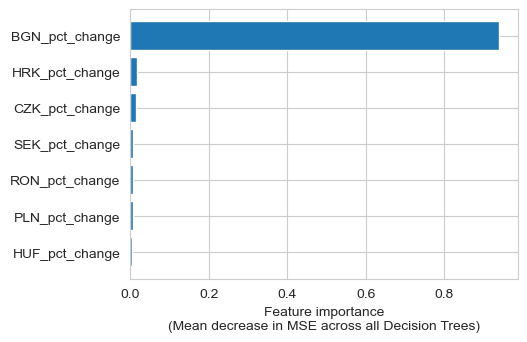

In [196]:
plot_feat_import(x_feat_list, rand_forest_regressor.feature_importances_, limit=10)

#### Removing the Bulgarian Lev, as is pegged to the Euro
It will always be the most influential feature, so we need to remove it. We are also removing the Czech Koruna, as it was pegged to the Euro from 2010-2017
[Source](https://www1.oanda.com/currency/iso-currency-codes/BGN#:~:text=The%20Lev%20is%20pegged%20to,current%20Bulgarian%20Lev%20(BGN))
[Source](https://www.barrons.com/articles/czech-currency-stronger-unpegged-from-euro-1491482433)

In [197]:
y_feat = 'EUR_pct_change'
# removing the bulgarian lev and czech koruna
non_bc_list = currencies[2:]
# new r2 value, without the Lev and koruna
rand_forest_regressor = disp_rfr_regress(eu_pct_df, non_bc_list, y_feat)

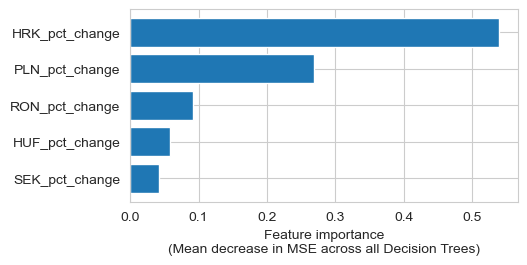

In [198]:
plot_feat_import(non_bc_list, rand_forest_regressor.feature_importances_, limit=10)

In [199]:
# initialize regression object
reg = LinearRegression()

# get target variable
x = eu_pct_df.loc[:, non_bc_list].values[1:]
y = eu_pct_df.loc[:, y_feat].values[1:]

# fit regression
reg.fit(x, y)

# compute / store r2
y_pred = reg.predict(x)

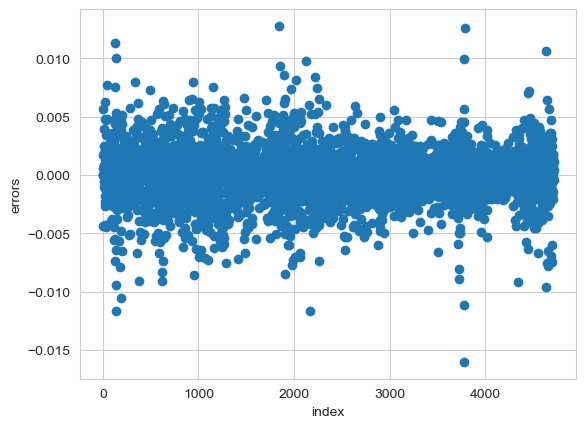

In [200]:
# check independence
errors = y - y_pred
plt.scatter(x = range(len(y)), y = errors)
plt.xlabel('index')
plt.ylabel('errors');

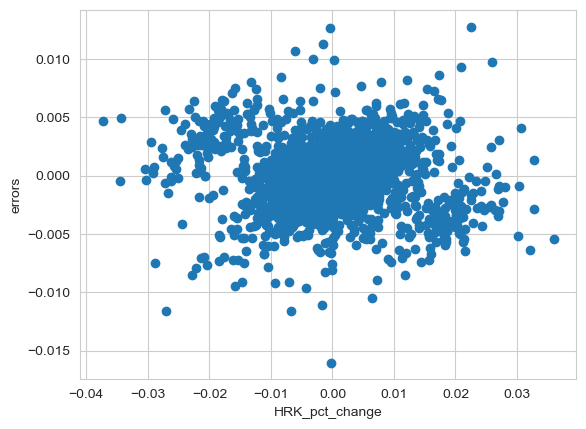

In [201]:
# check constant variance (HRK_pct_change)
plt.scatter(x = x[:,0], y = errors)
plt.xlabel('HRK_pct_change')
plt.ylabel('errors');

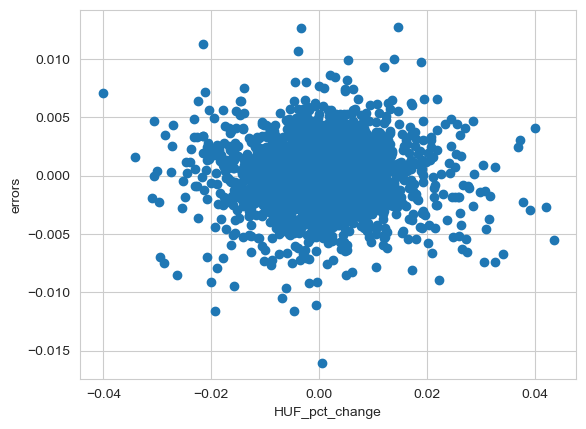

In [202]:
# check constant variance (HUF_pct_change)
plt.scatter(x = x[:,1], y = errors)
plt.xlabel('HUF_pct_change')
plt.ylabel('errors');

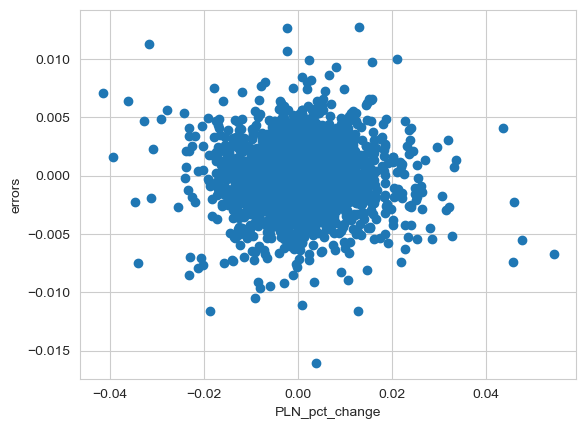

In [203]:
# check constant variance (PLN_pct_change)
plt.scatter(x = x[:,2], y = errors)
plt.xlabel('PLN_pct_change')
plt.ylabel('errors');

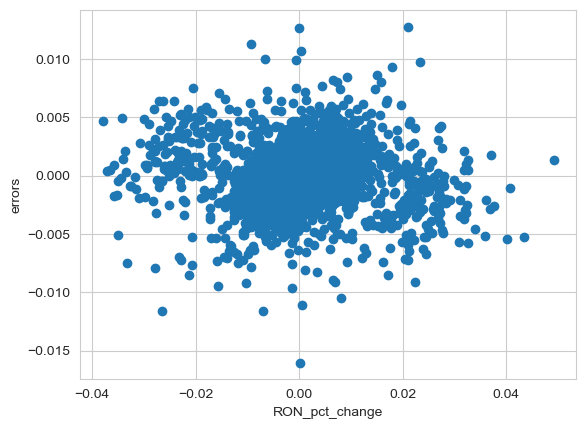

In [204]:
# check constant variance (RON_pct_change)
plt.scatter(x = x[:,3], y = errors)
plt.xlabel('RON_pct_change')
plt.ylabel('errors');

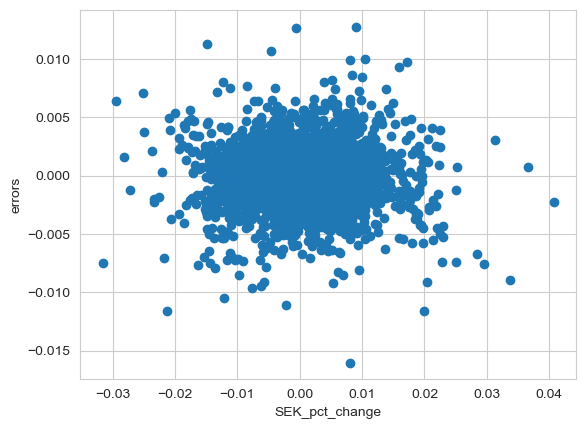

In [205]:
# check constant variance (SEK_pct_change)
plt.scatter(x = x[:,4], y = errors)
plt.xlabel('SEK_pct_change')
plt.ylabel('errors');

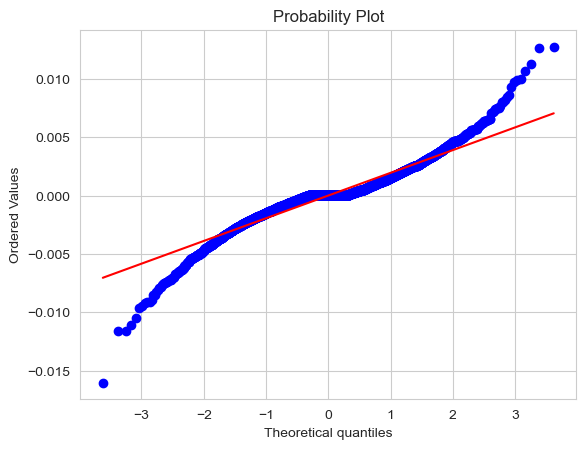

In [206]:
# check normality
stats.probplot(errors, dist="norm", plot=py)
py.show()

In [207]:
eu_r2 = disp_regress(eu_pct_df[1:], x_feat_list = non_bc_list, y_feat = 'EUR_pct_change')

EUR_pct_change = -0.00 + 0.15 HRK_pct_change + 0.14 HUF_pct_change + 0.19 PLN_pct_change + 0.04 RON_pct_change + 0.21 SEK_pct_change
r2 = 0.813


### Results

As seen above, we created Multiple Linear regression plots and calculated the R2 scores for the percentage changes between the non-Euro EU countries and the Euro. These 7 countries were the Bulgaria, Croatia, Czech Republic, Hungary, Poland, Romania, and Sweden. Denmark was not included in this calculation as they are on the opt-out system, not in the non Euro area.

Through a Multiple Linear Regression, we found that these features have a 0.86 r2. With a value this high, we deployed a feature importance graph and found that the Bulgarian had an extremely significant feature importance. Through further research, this currency was found to be pegged on the Euro, with Bulgaria having a plan to adopt the Euro by 2024. Interestingly enough, the Czech Koruna was pegged to the Euro from 2010-2017 but did not have a large feature importance.

Next, the Lev and Koruna were removed and the MLR was run on the other currencies. Producing an r2 value of 0.81, this was extremely interesting as it shows a strong level of variability explanation. The Croatian Kuna, with the highest level of feature importance, does not have a peg to the Euro, conveying a very important affect. These non-Euro EU countries excluding Bulgaria and Czech Republic show a significant change in line with a change in the Euro.

Source: [https://european-union.europa.eu/institutions-law-budget/euro/countries-using-euro_en](https://european-union.europa.eu/institutions-law-budget/euro/countries-using-euro_en)

## Discussion
Based on the outputs we were able to produce, using both Linear and Multiple Regression, our group considers this a comprehensive dive into the affect of currencies on each other. The regression models we built take into account the percent change of exchange rates. Most interestingly, we were able to analyze the relationship between Non-Euro using EU countries and the Euro. With the European Union being a political collection of 27 countries, some of which do not implement the common currency, we felt that the changes in the multiple features EU currencies would be able to give us a better understanding as to how the Euro moved. Most notabily, we were able to narrow down to the currencies of Croatia, Poland, Romania, Hungary, and Sweden. These countries do not have pegs to any other currencies or standards, yet together they strongly model the movement of the Euro.

To test the validity of our findings, we would simulate several investment decisions according to our model and look at the overall ROI at the end. For example, if we saw drastic downward movement in several currencies from above that explain variability in the Euro, we would simulate a sell and see if that was the correct decision afterward. Furthermore, because or models are linear and failed some the assumptions of independence, constant variance, and normality, our results can't be immediately taken for granted or completed trusted. Because of this, we believe that in the future, different models should be chosen that don't rely on these assumptions. Perhaps, we would use some forecasting model that was built for time-series data like the ARIMA model. This would allow us to address that underlying issue that time itself might be an influential variable that we weren't able to account for.

### Takeaway
Altogether, we feel that we have made good progress on exploring the effect of different currencies on each other in the Foreign Exchange market. To be utilized in the future, we need better economic understanding and currency exchange prediction data.